<a href="https://colab.research.google.com/github/Lirikman/neural_networks/blob/main/Russian_alphabet_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Постановка цели

* Написать нейросеть для распознавания букв русского алфавита
* Создать графический интерфейс для работой с нейросетью

### Установка и импорт необходимых библиотек

In [ ]:
import os                           # работа с файловой системой
import shutil                       # высокоуровневые операции с каталогами
import pandas as pd                 # работа с данными
import numpy as np                  # работа с массивами
import matplotlib.pyplot as plt     # визуализация данных
import cv2                          # обработка изображений
import skimage as ski               # обработка изображений
from PIL import Image               # работа с изображениями
import tensorflow as tf             # создание и обучение нейросетей
from tensorflow import keras        # глубокое машинное обучение
from keras import layers            # импортируем слои
from keras import models            # импортируем модели
import gradio as gr                 # работа с графическим интерфейсом
%matplotlib inline

### Загрузка данных

В качестве набора данных возьмём CoMNIST, а именно архив Cyrillic.zip с набором изображений русских букв - `https://github.com/GregVial/CoMNIST`

Скачаем и распакуем набор данных CoMNIST.

In [ ]:
!wget 'https://storage.yandexcloud.net/cyrilic/Cyrillic.zip'

--2025-07-06 08:23:32--  https://storage.yandexcloud.net/cyrilic/Cyrillic.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71657411 (68M) [application/x-zip-compressed]
Saving to: ‘Cyrillic.zip’

Cyrillic.zip        100%[===================>]  68.34M  22.2MB/s    in 3.1s    

2025-07-06 08:23:36 (22.2 MB/s) - ‘Cyrillic.zip’ saved [71657411/71657411]



In [ ]:
# распаковываем архив
!unzip "Cyrillic.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
         continuing with "central" filename version
  inflating: Cyrillic/Ь/58bf2c8774e99.png  
Cyrillic/Ь/58bf2f51a7ac8.png:  mismatching "local" filename (Cyrillic/╨м/58bf2f51a7ac8.png),
         continuing with "central" filename version
  inflating: Cyrillic/Ь/58bf2f51a7ac8.png  
Cyrillic/Ь/58bf2f594540d.png:  mismatching "local" filename (Cyrillic/╨м/58bf2f594540d.png),
         continuing with "central" filename version
  inflating: Cyrillic/Ь/58bf2f594540d.png  
Cyrillic/Ь/58bf2fb2f2978.png:  mismatching "local" filename (Cyrillic/╨м/58bf2fb2f2978.png),
         continuing with "central" filename version
  inflating: Cyrillic/Ь/58bf2fb2f2978.png  
Cyrillic/Ь/58bf2ff28900c.png:  mismatching "local" filename (Cyrillic/╨м/58bf2ff28900c.png),
         continuing with "central" filename version
  inflating: Cyrillic/Ь/58bf2ff28900c.png  
Cyrillic/Ь/58bf30213ad4c.png:  mismatching "local" filename (Cyrillic/╨м/58bf302

In [ ]:
# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './Cyrillic/'

# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 34, метки классов: ['I', 'Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']


Набор данных содержит 34 папки с названиями букв русского алфавита (А, Б, В, Г, Д и т.д.)

Удалим папку с названием I, так как эта буква не является буквой русского алфавита.

In [ ]:
shutil.rmtree('./Cyrillic/I')

# Определение актуального списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение актуального количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 33, метки классов: ['Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']


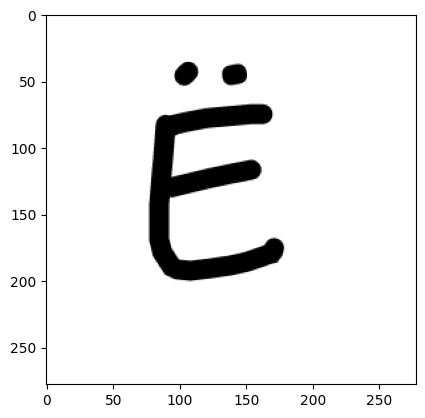

In [ ]:
# Выведем образец изображения буквы Ё

image = cv2.imread('./Cyrillic/Ё/58bc35664cbcd.png', cv2.IMREAD_UNCHANGED)

fig = plt.figure()
plt.imshow(image)
plt.show()

In [ ]:
# Список путей всех изображений
img_path = []

# выводим пути к папкам (dirpath) и наименования файлов (filenames)
for dirpath, _, filenames in os.walk('/content/Cyrillic'):

  # проходимся по названиям файлов
  for filename in filenames:

    # соединяем путь до папок и входящие в эти папки файлы
    img_path.append(os.path.join(dirpath, filename))

print('Всего изображений в наборе данных:', len(img_path))

Всего изображений в наборе данных: 15233


### Обработка данных

In [ ]:
# Посмотрим на размер изображения
print("Размер изображения -", image.shape)

Размер изображения - (278, 278, 4)


Из размера изображения видно, что изображения имеют четыре канала. Четвёртый канал — альфа-канал, он нам не нужен и мы его удаляем:

In [ ]:
def make_background(img):
    image = img
    file_without_extension = image.split('.')[0]
    image = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    trans_mask = image[:, :, 3] == 0
    image[trans_mask] = [255, 255, 255, 255]
    new_img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    cv2.imwrite(file_without_extension + '.png', new_img)

In [ ]:
# проходится в цикле по каждому файлу и удаляем альфа-канал
for img in img_path:
  make_background(img)

In [ ]:
# Посмотрим на результат работы функции
image_2 = cv2.imread('/content/Cyrillic/Ё/58a7656064aa0.png', cv2.IMREAD_UNCHANGED)
print("Размер изображения -", image_2.shape)

Размер изображения - (278, 278, 3)


Видим, что 4 - канал удалился, как нам и надо.

Посчитаем количество изображений в каждой отдельной папке:

In [ ]:
arr_len_files = []
for path in CLASS_LIST:
  name_path = 'Cyrillic/'+path+'/'
  files=os.listdir(name_path)
  arr_len_files.append(len(files))
  print(f"Папка '{path}', количество файлов: {len(files)}")

print('Максимальное количество файлов в классе:', max(arr_len_files))
print('Минимальное количество файлов в классе:', min(arr_len_files))

Папка 'Ё', количество файлов: 344
Папка 'А', количество файлов: 469
Папка 'Б', количество файлов: 444
Папка 'В', количество файлов: 487
Папка 'Г', количество файлов: 424
Папка 'Д', количество файлов: 465
Папка 'Е', количество файлов: 576
Папка 'Ж', количество файлов: 462
Папка 'З', количество файлов: 431
Папка 'И', количество файлов: 447
Папка 'Й', количество файлов: 466
Папка 'К', количество файлов: 459
Папка 'Л', количество файлов: 433
Папка 'М', количество файлов: 470
Папка 'Н', количество файлов: 508
Папка 'О', количество файлов: 465
Папка 'П', количество файлов: 474
Папка 'Р', количество файлов: 493
Папка 'С', количество файлов: 513
Папка 'Т', количество файлов: 456
Папка 'У', количество файлов: 551
Папка 'Ф', количество файлов: 463
Папка 'Х', количество файлов: 486
Папка 'Ц', количество файлов: 448
Папка 'Ч', количество файлов: 464
Папка 'Ш', количество файлов: 431
Папка 'Щ', количество файлов: 446
Папка 'Ъ', количество файлов: 459
Папка 'Ы', количество файлов: 415
Папка 'Ь', кол

 Из полученной информации видно, что количество данных совсем небольшое (344 — 576 изображений на класс).

 Соответственно, нам необходимо увеличить наши данные. Для этих целей будем использовать следующие приёмы:
 * сдвиги - перемещение буквы на какое-то значение вверх/вниз и влево/вправо по осям;
 * повороты - поворот буквы на какой-то определённый градус.

In [ ]:
# Функция сдвига изображения

def shift(img):
            image = img
            img = cv2.imread(image)
            file_without_extension = image.split('.')[0]
            arr_translation = [[15, -15], [-15, 15], [-15, -15],
                               [15, 15]]
            arr_caption=['15-15','-1515','-15-15','1515']
            for i in range(4):
                transform = ski.transform.AffineTransform(
                    translation=tuple(arr_translation[i]))
                warp_image = ski.transform.warp(img, transform, mode="wrap")
                img_convert = cv2.convertScaleAbs(warp_image,
                                                  alpha=(255.0))
                cv2.imwrite(file_without_extension +
                         arr_caption[i] + '.png', img_convert)

In [ ]:
# Применяем функцию сдвига изображения на нашем наборе
for img_file in img_path:
  shift(img_file)

In [ ]:
# Функция поворота изображения
def rotate(img):
    image = img
    img = Image.open(image)
    file_without_extension = image.split('.')[0]
    angles = np.ndarray((2,),
        buffer=np.array([-13, 13]), dtype=int)
    for angle in angles:
        transformed_image = ski.transform.rotate(np.array(img),
        angle, cval=255, preserve_range=True).astype(np.uint8)
        cv2.imwrite(file_without_extension +
                    str(angle) + '.png', transformed_image)

In [ ]:
# Применяем функцию поворота изображения на нашем наборе
for img_file in img_path:
  rotate(img_file)

### Балансировка данных

Посмотрим на количество файлов в каждой папке, после проведённых аффиных преобразований над изображениями:

In [ ]:
arr_len_files = []
for path in CLASS_LIST:
  name_path = 'Cyrillic/'+path+'/'
  files=os.listdir(name_path)
  arr_len_files.append(len(files))
  print(f"Папка '{path}', количество файлов: {len(files)}")

print('Максимальное количество файлов в классе:', max(arr_len_files))
print('Минимальное количество файлов в классе:', min(arr_len_files))

Видно, что количество изображений, принадлежащих к каждому классу увеличилось. Но данные разбалансированы, поэтому необходимо сбалансировать наш датасет.

Сбалансируем нам датасет по минимальному количеству изображений в классах, таким является класс буквы 'Ё' - 2408.

In [ ]:
def balancing(root_path, name_root_path):
    arr_len_files = []
    for path in root_path:
        name_path = name_root_path+path+'/'
        files=os.listdir(name_path)
        arr_len_files.append(len(files))

    min_value=min(arr_len_files)
    for path in root_path:
        folder = name_root_path+path
        arr = []
        for the_file in os.listdir(folder):
            arr.append(folder + '/' + the_file)
        d = 0
        k = len(arr)
        for i in arr:
            if d == k - min_value:
              break
            os.remove(i)
            d += 1

In [ ]:
# Применим функцию балансировки к нашему набору данных
balancing(CLASS_LIST, 'Cyrillic/')

В результате выполнения балансировки, для каждой буквы количество изображений стало одинаковым - 2408 шт.

### Создание обучающей базы

Чтобы создать обучающую базу, нам понадобится список всех картинок букв, а также список номеров (меток) класса для них в том же порядке. То есть, например, для третьего по порядку файла в списке файлов метка его класса будет третьей в списке меток.

Сейчас изображения букв каждого класса лежат в отдельных папках. Загружая изображения, мы можем сразу записывать порядковый номер папки как метку класса животного в соответствующий список.

Количество классов равно CLASS_COUNT - 33.

Пробежимся по содержимому папок, получим имена файлов изображений, соберем их в список data_files, а в список data_labels соберем номера (метки) классов:

In [ ]:
data_files = []  # Cписок путей к файлам изображений
data_labels = [] # Список меток классов

for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Полный путь к папке с изображениями класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(class_path)

    # Вывод информации о численности класса
    print(f'Размер класса {class_name} составляет {len(class_files)} изображений')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print('Общий размер базы для обучения:', len(data_labels))

### Расщепление набора данных на обучающую, проверочную и контрольную выборку

Далее следует разделить данные на обучающие, проверочные и контрольные в соотношении 70%, 20% и 10% соответственно.

Создадим папки для обучающей, проверочной и контрольной выборок:

In [ ]:
# Папка в которой будем создавать выборки
BASE_DIR = './dataset/'

# При повторном запуске пересоздаим структуру каталогов
# Если папка существует, то удаляем ее со всеми вложенными каталогами и файлами
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

# Создаем папку по пути BASE_DIR
os.mkdir(BASE_DIR)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'train'
train_dir = os.path.join(BASE_DIR, 'train')

# Создаем подпапку, используя путь
os.mkdir(train_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'validation'
validation_dir = os.path.join(BASE_DIR, 'validation')

# Создаем подпапку, используя путь
os.mkdir(validation_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'test'
test_dir = os.path.join(BASE_DIR, 'test')

# Создаем подпапку, используя путь
os.mkdir(test_dir)

In [ ]:
# Функция создания подвыборок (папок с файлами)
def create_dataset(
    img_path: str,         # Путь к файлам с изображениями классов
    new_path: str,         # Путь к папке с выборками
    class_name: str,       # Имя класса (оно же и имя папки)
    start_index: int,      # Стартовый индекс изображения, с которого начинаем подвыборку
    end_index: int         # Конечный индекс изображения, до которого создаем подвыборку

):

    src_path = os.path.join(img_path, class_name)  # Полный путь к папке с изображениями класса
    dst_path = os.path.join(new_path, class_name)  # Полный путь к папке с новым датасетом класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(src_path)

    # Создаем подпапку, используя путь
    os.mkdir(dst_path)

    # Перебираем элементы, отобранного списка с начального по конечный индекс
    for fname in class_files[start_index : end_index]:
        # Путь к файлу (источник)
        src = os.path.join(src_path, fname)
        # Новый путь расположения файла (назначение)
        dst = os.path.join(dst_path, fname)
        # Копируем файл из источника в новое место (назначение)
        shutil.copyfile(src, dst)

In [ ]:
len_folder = len(os.listdir('Cyrillic/Ё/'))
print('Количество файлов в папках набора данных:', len_folder)
end_index_train = int(len_folder*0.7)
print('Конечный индекс для обучающей выборки:', end_index_train)
end_index_test = int(len_folder*0.9)
print('Конечный индекс для проверочной выборки:', end_index_test)
print('Конечный индекс для контрольной выбокри:', len_folder-1)

In [ ]:
for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен

    # Создаем обучающую выборку для заданного класса из диапазона (0-1685)
    create_dataset(IMAGE_PATH, train_dir, class_name, 0, end_index_train)
    # Создаем проверочную выборку для заданного класса из диапазона (1685-2167)
    create_dataset(IMAGE_PATH, validation_dir, class_name, end_index_train, end_index_test)
    # Создаем тестовую выборку для заданного класса из диапазона (2167-2407)
    create_dataset(IMAGE_PATH, test_dir, class_name, end_index_test, len_folder-1)


С целью проверки подсчитаем, сколько изображений каждого класса оказалось в каждом наборе (обучающем/тестовом/проверочном):

In [ ]:
print('Обучающая выборка:')
for path in CLASS_LIST:
  name_path = train_dir+'/'+path+'/'
  files=os.listdir(name_path)
  print(f"Папка '{path}', количество файлов: {len(files)}")

print('Проверочная выборка:')
for path in CLASS_LIST:
  name_path = validation_dir+'/'+path+'/'
  files=os.listdir(name_path)
  print(f"Папка '{path}', количество файлов: {len(files)}")

print('Тестовая выборка:')
for path in CLASS_LIST:
  name_path = test_dir+'/'+path+'/'
  files=os.listdir(name_path)
  print(f"Папка '{path}', количество файлов: {len(files)}")

Таким образом, мы видим, что у нас имеется 1686 обучающих, 482 проверочных и 240 контрольных изображений. Каждый набор содержит одинаковое количество образцов каждого класса: это сбалансированная задача многоклассовой классификацииа.

Таким образом мы получили сбалансированные выборки. И можно приступить к созданию и обучению модели.

### Обучение нейронной сети

In [ ]:
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                              batch_size=40,
                              color_mode='grayscale',
                              class_mode='binary',
                              target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                      batch_size=40,
                                      color_mode='grayscale',
                                      class_mode='binary',
                                      target_size=(150, 150))

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                           input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(33, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(train_generator,
                    epochs=4,
                    verbose=1,
                    validation_data=validation_generator)

model.save('my_model.keras')

Самый длительный этап — обучение сети. В качестве нейронной сети выбраем CNN, так как она хорошо подходит для классификации объектов.

Сам процесс обучения занимает 90 - 120 мин. и точность составила примерно 93%, что довольно хорошо.

После обучения модели мые её сохранили, для дальнейшего использования.

### Оценка качества модели

 Проверим, нашу нейронную сеть на валидационных изображениях - контрольной выборке, для того, чтобы убедиться, что точность на тестовых данных соответствует реальности:

In [ ]:
# Скачиваем обученную и сохранёнуя модель с yandex.cloud
!wget 'https://storage.yandexcloud.net/cyrilic/my_model.keras'

In [ ]:
# Указываем путь к модели
path_model = '/content/my_model.keras'

# Функция вывода результата
def print_letter(result):
    letters = "ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"
    return letters[result]

# Функция предсказания модели
def predicting(path_to_image):
    image = keras.preprocessing.image
    model = keras.models.load_model(path_model)
    img = image.load_img(path_to_image, color_mode='grayscale', target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=1)
    result = int(np.argmax(classes))
    result = print_letter(result)
    print(result)

In [ ]:
# Проверка работы

path_img_yo = '/content/dataset/test/Ё/58bc2bf6566b7-13.png' # путь к букве Ё
path_img_zh = '/content/dataset/test/Ж/5a02239c96183-1515.png' # путь к букве Ж
path_img_f = '/content/dataset/test/Ф/58be9290848f815-15.png' # путь к букве Ф
path_img_sch = '/content/dataset/test/Щ/58be8d26cf943-13.png' # путь к букве Щ
path_img_yu = '/content/dataset/test/Ю/58be8c59495b8-15-15.png' # путь к букве Ю

predicting(path_img_yo)
predicting(path_img_zh)
predicting(path_img_f)
predicting(path_img_sch)
predicting(path_img_yu)

### ВЫВОД:

Все буквы из контрольной выборки модель определила правильно.

Нейросеть хорошо справилась с поставленной задачей!

### Создание графического интерфейса

In [ ]:
from google.colab import files
import tensorflow as tf
from tensorflow import keras
import gradio as gr
import os
import shutil
from skimage import io

# Создание папок с выборками
BASE_DIR = './dataset/'

# При повторном запуске пересоздаим структуру каталогов
# Если папка существует, то удаляем ее со всеми вложенными каталогами и файлами
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

# Создаем папку по пути BASE_DIR
os.mkdir(BASE_DIR)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'train'
train_dir = os.path.join(BASE_DIR, 'train')

# Создаем подпапку, используя путь
os.mkdir(train_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'validation'
validation_dir = os.path.join(BASE_DIR, 'validation')

# Создаем подпапку, используя путь
os.mkdir(validation_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'test'
test_dir = os.path.join(BASE_DIR, 'test')

# Создаем подпапку, используя путь
os.mkdir(test_dir)

# Функция загрузки обработанного набора данных
def download_dataset(button):
  !wget 'https://storage.yandexcloud.net/cyrilic/my_dataset.zip'
  return 'Загрузка данных успешно выполнена!'

# Функция распаковки датасета
def unzip_dataset(button):
  !unzip my_dataset.zip
  return 'Набор данных успешно распакован!'


# Архитектура
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                           input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(33, activation='softmax')
  ])

# Компиляция модели
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Функция обучения модели
def train_model(button, epochs):
  # Предобработка ихображений и определение архитектуры модели
  ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
  train_datagen = ImageDataGenerator(rescale=1./255)
  validation_datagen = ImageDataGenerator(rescale=1./255)
  train_generator = train_datagen.flow_from_directory(train_dir,
                              batch_size=40,
                              color_mode='grayscale',
                              class_mode='binary',
                              target_size=(150, 150))
  validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                      batch_size=40,
                                      color_mode='grayscale',
                                      class_mode='binary',
                                      target_size=(150, 150))
  model.fit(train_generator,
            epochs=epochs,
            verbose=1,
            validation_data=validation_generator)
  model.save('my_model.keras')
  return 'Обучение модели успешно выполнено!'

# Функция сохранения обученной модули
def save_my_model(button):
  files.download('my_model.keras')
  return 'Обученная модель успешно сохранена!'

# Функция загрузки обученной модели
def download_model(button):
  !wget 'https://storage.yandexcloud.net/cyrilic/my_model.keras'
  return 'Модель успешно загружена!'

# Функция вывода результата
def print_letter(result):
    letters = "ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"
    return letters[result]

# Функция проверки модели
def predict_model(image):
  if image is not None:
    model = keras.models.load_model('my_model.keras')
    img = keras.preprocessing.image.load_img(image, color_mode='grayscale', target_size=(150, 150))
    x = keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    prediction = model.predict(images, batch_size = 1)
    result = int(np.argmax(prediction))
    result = print_letter(result)
    return result
  else:
    return 'Загрузите изображение!'

with gr.Blocks(css=".gradio-container {background-color: #87CEEB}") as demo:
    gr.Markdown(
    """
    ## Нейросеть **"Распознавание букв русского алфавита"**

    ## *Процесс создания*

    В качестве набора данных был использован датасет `CoMNIST` - архив Cyrillic.zip, с набором изображений русских букв.

    Ссылка на ресурс: https://github.com/GregVial/CoMNIST

    Набор данных содержит 34 папки с названиями букв русского алфавита (А, Б, В, Г, Д и т.д.), и папку с буквой I.

    В каждой папке находятся изображения формата .png и размера - 278 x 278 с буквой названия папки.

    **Набор данных был предварительно обработан:**
    - Удалена папка с буквой I, так как она не является буквой русского алфавита;
    - Удалён альфа-канал в изображения;
    - Проведено расширение набора данных с помощью аффиных преобразований - сдвига и поворота изображения;
    - Проведена балансировка набора данных, для достижения одинакового количества изображений всех букв;

    Было произведено разделение набора данных на тренировочную, тестовую и контрольную выборки.

    **Перед обучением модели нейросети изображения были обработаны:**
    1. Декодированы из формата PNG в таблицы пикселей GRAYSCALE;
    2. Преобразованы в тензоры с вещественными числами;
    3. Масштабированы значения пикселей из диапазона [0, 255] в диапазон [0, 1].

    **Набор данных был предварительно обработан:**
    - Удалена папка с буквой I, так как она не является буквой русского алфавита;
    - Удалён альфа-канал в изображения;
    - Проведено расширение набора данных с помощью аффиных преобразований - сдвига и поворота изображения;
    - Проведена балансировка набора данных, для достижения одинакового количества изображений всех букв;

    ## *Обучение модели*

    **Процесс обучения модели долгий и длится примерно от 60 до 120 мин.**

    Для начала обучения модели загрузим готовый и обработанный набор данных:
    """)

    downl_data = gr.Button("Загрузить набор данных")
    output = gr.Textbox(label="СТАТУС ЗАГРУЗКИ")
    downl_data.click(download_dataset, downl_data, output, show_progress = True)

    gr.Markdown(
    """
    Распакуем скачанный набор данных:
    """)

    unzip_data = gr.Button("Распаковать набор данных")
    status_unzip = gr.Textbox(label="СТАТУС РАСПАКОВКИ")
    unzip_data.click(unzip_dataset, unzip_data, status_unzip, show_progress = True)

    gr.Markdown(
    """
    Теперь можно приступить к обучению модели:
    """)
    train_my_model = gr.Button("Обучить нейросеть")
    options = [1, 2, 3, 4]
    quantity_epochs = gr.Dropdown(options, label='Количество эпох обучения')
    train_status = gr.Textbox(label="СТАТУС ОБУЧЕНИЯ")
    train_my_model.click(train_model, [train_my_model, quantity_epochs], train_status, show_progress = True)

    gr.Markdown(
    """
    Обученную модель можно сохранить себе на компьютер:
    """)

    save_model = gr.Button("Сохранить обученную модель")
    status_save_model = gr.Textbox(label="СТАТУС СОХРАНЕНИЯ")
    save_model.click(save_my_model, save_model, status_save_model, show_progress = True)

    gr.Markdown(
    """
    ## *Проверка работы нейросети*
    Для проверки работы нейросети можно загрузить уже обученную модель:
    """)

    downl_model = gr.Button("Загрузить обученную модель")
    status_downl_model = gr.Textbox(label="СТАТУС ЗАГРУЗКИ")
    downl_model.click(download_model, downl_model, status_downl_model, show_progress = True)

    gr.Markdown(
    """
    ## *Интерфейс загрузки тестового изображения*
    Для проверки работы модели нейросети выберите изображение с русской буквой на вашем ПК:
    """)

    iface = gr.Interface(
        fn=predict_model,
        inputs=gr.Image(label='Изображение', height=200, width=200, type='filepath'),
        outputs=gr.Textbox(label='Результат'),
        live=True
        )

demo.launch(debug=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8668dcd631716e27eb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8668dcd631716e27eb.gradio.live
